In [1]:
#himport modin.pandas as pd
import socketio
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import boxcox 
from scipy.special import boxcox1p
import random

initial = True
batchSize = 2500
tweets_table = "energyeast_preprocessed_tweets_urls"
images_table = "energyeast_images"
urls_table = ""
query = "SELECT id, retweet_count, like_count, reply_count, quote_count, emojis_count, handles_count, engagement_rate, extended_reach, possible_impressions, urls_count, hashtags_count, text_pv_freq, text_humour_freq, text_sentiment_freq FROM " + tweets_table + " WHERE type != 'retweet' ORDER BY id LIMIT " + str(batchSize)
tweets = False
images = False
urls = False

allTweets = []
allImages = []
flattenedTweets = []
flattenedImages = []
parsedTweets = []
parsedImages = []

analyses_variables = [
    {
        "dv": "engagement_rate", #1-way anova
        "ivs": ["emojis_count"], 
        "bins_names": ["emojis_bins"], 
        "bins_labels": [['None', 'One', 'Multiple']]
    },
    {
        "dv": "engagement_rate", #2/factorial/n-way anova
        "ivs": ["emojis_count", "hashtags_count"],
        "bins_names": ["emojis_bins", "hashtags_bins"],
        "bins_labels": [['None', 'One', 'Multiple'], ['None', 'One', 'Multiple']]
    }
]

#"query_type": "hashtag",
#"query_type": "hashtag", #if this is keywords, bins_labels for hashtags_count needs to be adjusted to ['None', 'One', 'Multiple']
#"type": "1-anova", #1-iv and 1-dv
#"type": "n-anova", #many-ivs and 1-dv / also works as a two-way anova / known as factorial anova

'''
    {
        "type": "1-manova", #1-iv and many-dvs
        "variables": {
            "dv": ["retweet_count", "like_count", "engagement_rate"], 
            "iv": "emojis_count", 
            "bins_name": "emojis_bins", 
            "bins_labels": ['low', 'medium', 'high']
        }
    },
    {
        "type": "2-manova", #2-ivs and many-dvs
        "variables": {
            "dv": ["retweet_count", "like_count", "engagement_rate"], 
            "iv": ["emojis_count", "hashtags_count"], 
            "bins_name": ["emojis_bins", "hashtags_bins"], 
            "bins_labels": [['low', 'medium', 'high'], ['low', 'medium', 'high']]
        }
    }
    '''

sio = socketio.Client()

In [2]:
def sentiment_tag(score):
    if score >= 0.05:
        return "positive"
    elif score <= - 0.05:
        return "negative"
    else:
        return "neutral"

def binning(df, column_name, bins_names, quantity, bins_labels):
    if column_name == "emojis_count" or column_name == "handles_count" or  column_name == "hashtags_count":
        df[bins_names] = pd.cut(df[column_name], [float("-inf"),0,1,float("inf")], labels=bins_labels)
    #elif column_name == "hashtags_count":
    #    if query_type == "hashtag":
    #        df[bins_names] = pd.cut(df[column_name], [float("-inf"),0,1,float("inf")], labels=bins_labels)
            #df[bins_names] = pd.cut(df[column_name], [1,2,float("inf")], labels=bins_labels)
    #    else:
    #        df[bins_names] = pd.cut(df[column_name], [float("-inf"),0,1,float("inf")], labels=bins_labels)
    else:
        df[bins_names] = pd.qcut(df[column_name], quantity, labels=bins_labels)
    return df

'''
def get_sample_size(df, bins_names):
    sizes = []
    for bin_name in bins_names:
        size = df.groupby(bin_name).size().values.tolist()
        sizes.append(size)
    flat_sizes = [item for sublist in sizes for item in sublist]
    sampleSize = min(flat_sizes)
    return sampleSize

def create_sample_df(df, dv, ivs, bins_names, bins_labels, sampleSize): #missing pandas selection for appropiate sample size depending on all the bins sizes, afterwards it needs a way for doing grouping and bring back a df with all bins
    samples = []
    for i in range(0, len(bins_names)):
        sample_df = df.groupby(bins_names[i], as_index=False)[ivs[i]].apply(lambda s: s.sample(sampleSize))
        samples.append(sample_df.reset_index(drop=True))
    
    dv_sample_size = len(bins_labels[0])*sampleSize
    sample_df = df.sample(dv_sample_size)
    samples.append(sample_df[dv].reset_index(drop=True))
    
    samples_df = pd.concat(samples, axis=1)
    print(samples_df)
    return samples_df
'''

def fit_model(df, ivs, dv, bins_column_name):
    categories = ""
    lastC = ""
    if len(ivs) == 1:
        model = ols(dv + ' ~ C(' + bins_column_name[0] + ')', data = df).fit()
    else:
        for i in range(0, len(ivs)):  
            categories += "C(" + bins_column_name[i] + ")"
            #lastC += "C(" + bins_name[i] + ")"
            if i+1 < len(ivs):
                categories += " + "
                #lastC += ":"
        formula = dv + ' ~ ' + categories #+ " + " + lastC
        model = ols(formula, data = df).fit()
    return model

def get_simple_anova(model):
    anova_result = sm.stats.anova_lm(model, typ=2)
    return anova_result

'''
def get_manova(model):
    anova_result = model.mv_test()
    return anova_result
'''

'''
def anova_1_bins(df, iv, dv, bins_name, bins_labels):
    min_iv_value = df[iv].min()
    max_iv_value = df[iv].max()
    bins = np.linspace(min_iv_value, max_iv_value, len(bins_labels)+1)
    df[bins_name] = pd.cut(df[iv], bins=bins, labels=bins_labels, include_lowest=True)
    model = ols(dv + ' ~ C(' + bins_name + ')', data = df).fit()
    return model

def anova_n_bins(df, ivs, dv, bins_name, bins_labels):
    categories = ""
    lastC = ""
    for i in range(0, len(ivs)):  
        min_iv_value = df[ivs[i]].min()
        max_iv_value = df[ivs[i]].max()
        bins = np.linspace(min_iv_value, max_iv_value, len(bins_labels[i])+1)
        df[bins_name[i]] = pd.cut(df[ivs[i]], bins=bins, labels=bins_labels[i], include_lowest=True)
        categories += "C(" + bins_name[i] + ")"
        #lastC += "C(" + bins_name[i] + ")"
        if i+1 < len(ivs):
            categories += " + "
            #lastC += ":"
    formula = dv + ' ~ ' + categories #+ " + " + lastC
    model = ols(formula, data = df).fit()
    return model

def manova_1_bins(df, iv, dv, bins_name, bins_labels):
    min_iv_value = df[iv].min()
    max_iv_value = df[iv].max()
    bins = np.linspace(min_iv_value, max_iv_value, len(bins_labels)+1)
    df[bins_name] = pd.cut(df[iv], bins=bins, labels=bins_labels, include_lowest=True)
    dvs = ' + '.join([elem for elem in dv])
    model = MANOVA.from_formula(dvs + ' ~ C(' + bins_name + ')', data = df)
    return model

def manova_2_bins(df, ivs, dv, bins_name, bins_labels):
    categories = ""
    lastC = ""
    for i in range(0, len(ivs)):  
        min_iv_value = df[ivs[i]].min()
        max_iv_value = df[ivs[i]].max()
        bins = np.linspace(min_iv_value, max_iv_value, len(bins_labels[i])+1)
        df[bins_name[i]] = pd.cut(df[ivs[i]], bins=bins, labels=bins_labels[i], include_lowest=True)
        categories += "C(" + bins_name[i] + ")"
        #lastC += "C(" + bins_name[i] + ")"
        if i+1 < len(ivs):
            categories += " + "
            #lastC += ":"
    dvs = ' + '.join([elem for elem in dv])
    formula = dvs + ' ~ ' + categories #+ " + " + lastC
    model = MANOVA.from_formula(formula, data = df)
    return model
'''

def runAnalyses():
    for arr in flattenedTweets:
        arrDict = {'id': arr[0], 'retweet_count': arr[1], 'like_count': arr[2], 'reply_count': arr[3], 'quote_count': arr[4], 'emojis_count': arr[5], 'handles_count': arr[6], 'engagement_rate': arr[7], 'extended_reach': arr[8], 'possible_impressions': arr[9], 'urls_count': arr[10], 'hashtags_count': arr[11], 'text_pv_freq': arr[12], 'text_humour_freq': arr[13], 'text_sentiment_freq': arr[14]}
        parsedTweets.append(arrDict)

    original_df = pd.DataFrame(parsedTweets)
    
    #Samples number = get the size of the group with the lowest count
    #If the data from the samples do not follow a uniform distribution, keep it it like that - future work can apply a tranformation with it, maybe with box cox
    
    for variables in analyses_variables:
        df = original_df.copy()
        #print("N-Way Anova -> " + "IV: " + ', '.join([elem for elem in variables['variables']['iv']]) + " - " + "DVs: " + variables['variables']['dv'])
        for i in range(0, len(variables['ivs'])):
            df = binning(df, variables['ivs'][i], variables['bins_names'][i], len(variables['bins_labels'][i]), variables['bins_labels'][i])
            df_boxplot = df.boxplot(variables['dv'], by=variables['bins_names'][i], figsize=(12, 8))
            df_boxplot.set_xlabel(variables['bins_names'][i], fontsize=15)
            xlabels = df[variables['bins_names'][i]].unique()
            df_boxplot.set_xticklabels(xlabels)
            df_boxplot.set_ylabel(variables['dv'], fontsize=15)
            plt.title('')
            plt.suptitle('')
            plt.ylim(-0.5, 5)
            plt.tick_params(axis='y', labelsize=15)
            plt.tick_params(axis='x', labelsize=15)
            plt.show()
         
        #sampleSize = get_sample_size(df, variables['bins_names'])
        #sample_df = create_sample_df(df, variables['dv'], variables['ivs'], variables['bins_names'], variables['bins_labels'], sampleSize)
        model = fit_model(df, variables['ivs'], variables['dv'], variables['bins_names'])
        anova_result = get_simple_anova(model)
        print("Anova Result:")
        print(anova_result)
        print(" ")
        
    '''
        #One-Way Anova
        if variables["type"] == "1-anova":
            model = anova_1_bins(df, variables['variables']['iv'], variables['variables']['dv'],  variables['variables']['bins_name'], variables['variables']['bins_labels'])
            anova_result = get_simple_anova(model)
            print("One-Way Anova -> " + "IV: " + variables['variables']['iv'] + " - " + "DV: " + variables['variables']['dv'])
            print(anova_result)
            df_boxplot = df.boxplot(variables['variables']['dv'], by=variables['variables']['bins_name'], figsize=(12, 8))
            df_boxplot.set_xlabel(variables['variables']['bins_name'], fontsize=15)
            df_boxplot.set_ylabel(variables['variables']['dv'], fontsize=15)
            #plt.xticks([1, 2, 3], variables['variables']['bins_name'], fontsize=15)
            plt.title('')
            plt.suptitle('')
            plt.ylim(-0.5, 50)
            plt.tick_params(axis='y', labelsize=15)
            plt.tick_params(axis='x', labelsize=15)
            plt.show()
            print(" ")
        #N-Way Anova
        elif variables["type"] == "n-anova":
            model = anova_n_bins(df, variables['variables']['iv'], variables['variables']['dv'],  variables['variables']['bins_name'], variables['variables']['bins_labels'])
            anova_result = get_anova(model)
            print("N-Way Anova -> " + "IV: " + ', '.join([elem for elem in variables['variables']['iv']]) + " - " + "DVs: " + variables['variables']['dv'])
            print(anova_result)
            for i in range(0, len(variables['variables']['iv'])):
                df_boxplot = df.boxplot(variables['variables']['dv'], by=variables['variables']['bins_name'][i], figsize=(12, 8))
                df_boxplot.set_xlabel(variables['variables']['bins_name'][i], fontsize=15)
                df_boxplot.set_ylabel(variables['variables']['dv'], fontsize=15)
                #plt.xticks([1, 2, 3], variables['variables']['bins_name'][i], fontsize=15)
                plt.title('')
                plt.suptitle('')
                plt.ylim(-0.5, 50)
                plt.tick_params(axis='y', labelsize=15)
                plt.tick_params(axis='x', labelsize=15)
                plt.show()
            print(" ")
        #One-Way Manova
        elif variables["type"] == "1-manova":
            model = manova_1_bins(df, variables['variables']['iv'], variables['variables']['dv'],  variables['variables']['bins_name'], variables['variables']['bins_labels'])
            manova_result = get_manova(model)
            print("One-Way Manova -> " + "IV: " + variables['variables']['iv'] + " - " + "DVs: " + ', '.join([elem for elem in variables['variables']['dv']]))
            print(manova_result)
            for i in range(0, len(variables['variables']['dv'])):
                df_boxplot = df.boxplot(variables['variables']['dv'][i], by=variables['variables']['bins_name'], figsize=(12, 8))
                df_boxplot.set_xlabel(variables['variables']['bins_name'], fontsize=15)
                df_boxplot.set_ylabel(variables['variables']['dv'][i], fontsize=15)
                #plt.xticks([1, 2, 3], variables['variables']['bins_name'], fontsize=15)
                plt.title('')
                plt.suptitle('')
                plt.ylim(-0.5, 50)
                plt.tick_params(axis='y', labelsize=15)
                plt.tick_params(axis='x', labelsize=15)
                plt.show()
            print(" ")
        #Two-Way Manova
        elif variables["type"] == "2-manova":
            model = manova_2_bins(df, variables['variables']['iv'], variables['variables']['dv'],  variables['variables']['bins_name'], variables['variables']['bins_labels'])
            manova_result = get_manova(model)
            print("Two-Way Manova -> " + "IVs: " + ', '.join([elem for elem in variables['variables']['iv']]) + " - " + "DVs: " + ', '.join([elem for elem in variables['variables']['dv']]))
            print(manova_result)
            for i in range(0, len(variables['variables']['bins_name'])):
                for j in range(0, len(variables['variables']['dv'])):
                    df_boxplot = df.boxplot(variables['variables']['dv'][j], by=variables['variables']['bins_name'][i], figsize=(12, 8))
                    df_boxplot.set_xlabel(variables['variables']['bins_name'][i], fontsize=15)
                    df_boxplot.set_ylabel(variables['variables']['dv'][j], fontsize=15)
                    #plt.xticks([1, 2, 3], variables['variables']['bins_name'][i], fontsize=15)
                    plt.title('')
                    plt.suptitle('')
                    plt.ylim(-0.5, 50)
                    plt.tick_params(axis='y', labelsize=15)
                    plt.tick_params(axis='x', labelsize=15)
                    plt.show()
            print(" ")
    '''
    sio.wait()
    
    #min_emojis_value = df['emojis_count'].min()
    #max_emojis_value = df['emojis_count'].max()
    #print(min_value)
    #print(max_value)

    #emojis_bins = np.linspace(min_emojis_value,max_emojis_value,4)
    #print(bins)
    #emojis_labels = ['low', 'medium', 'high']
    #df['emojis_bins'] = pd.cut(df['emojis_count'], bins=emojis_bins, labels=emojis_labels, include_lowest=True)
    #df['emojis_bins'] = pd.qcut(df['emojis_count'], q=3, precision=1, labels=labels)

    #emojis_group = df.groupby('emojis_bins').groups

    #low = df['retweet_count'][emojis_group['low']]
    #medium = df['retweet_count'][emojis_group['medium']]
    #high = df['retweet_count'][emojis_group['high']]
    #print(stats.f_oneway(low, medium, high))
    #print(stats.kruskal(low, medium, high))

connected


Failed to set SIGTERM handler, processes mightnot be cleaned up properly on exit.
To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2022-03-09 23:03:38,634	WARNING services.py:1816 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


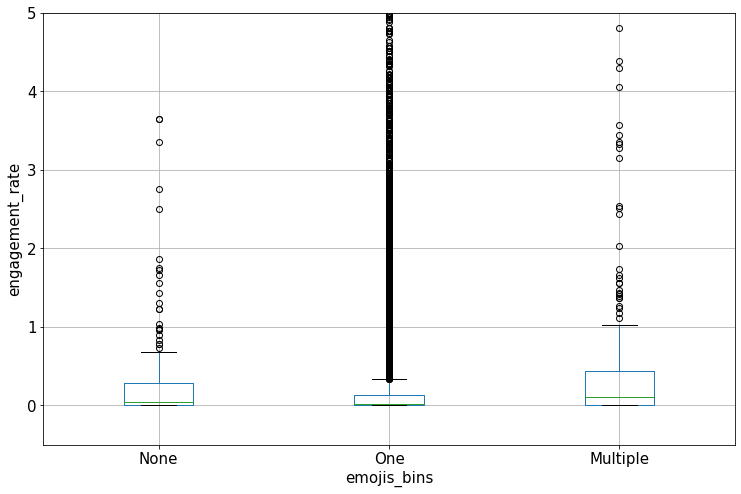

Anova Result:
                      sum_sq       df         F    PR(>F)
C(emojis_bins)  1.404874e+03      2.0  3.278891  0.037681
Residual        7.974071e+06  37222.0       NaN       NaN
 


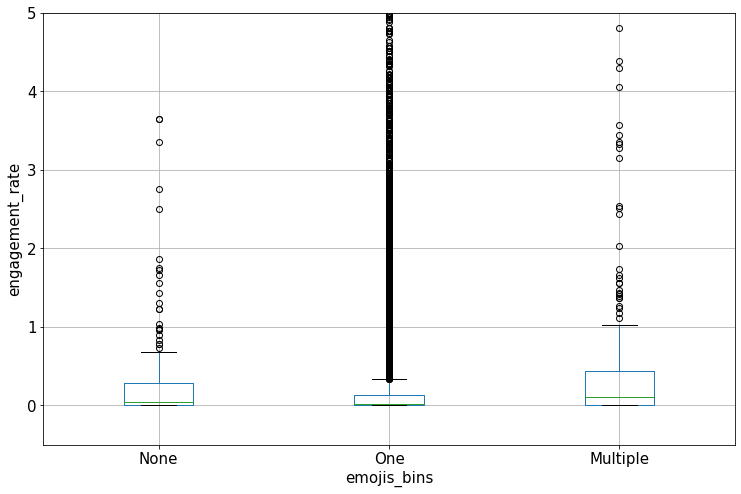

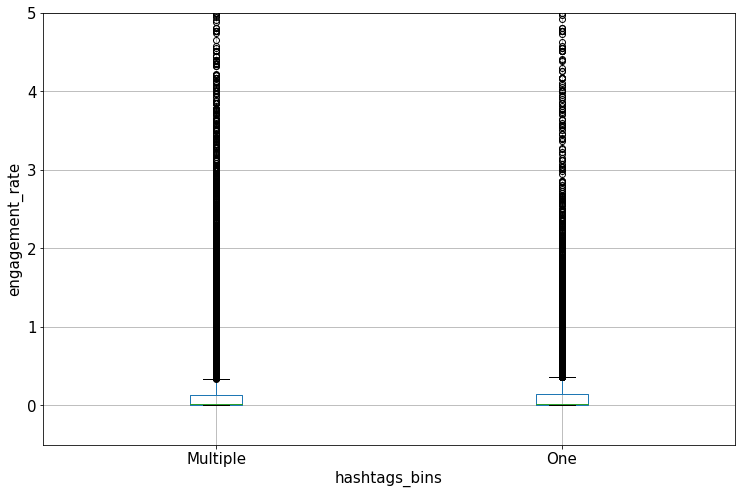

Anova Result:
                        sum_sq       df         F    PR(>F)
C(emojis_bins)    1.360862e+03      2.0  3.176301  0.041751
C(hashtags_bins)  5.427505e+02      1.0  2.533598  0.111454
Residual          7.973529e+06  37221.0       NaN       NaN
 


In [3]:
@sio.event
def connect():
    #global query
    print('connected')
    if(initial):
        sio.emit('crate_query', query)
        intial = False

@sio.event
def disconnect():
    print('disconnected')

sio.connect('http://129.128.215.129:81/ws', socketio_path="/ws/socket.io", wait_timeout = 10)
#sio.wait()

@sio.on('crate_response')
def on_message(data):
    global tweets, images, allTweets, allImages, flattenedTweets, flattenedImages, query
    if(len(data) > 0 or len(data) == 1):
        if not tweets:
            lastID = data[len(data) - 1][0]
            query = "SELECT id, retweet_count, like_count, reply_count, quote_count, emojis_count, handles_count, engagement_rate, extended_reach, possible_impressions, urls_count, hashtags_count, text_pv_freq, text_humour_freq, text_sentiment_freq FROM " + tweets_table + " WHERE type != 'retweet' AND id > " + str(lastID) + " ORDER BY id LIMIT " + str(batchSize)
            allTweets.append(data)
        elif not images:
            lastID = data[len(data) - 1][0]
            query = "SELECT * FROM " + images_table + " WHERE id > " + str(lastID) + " ORDER BY id LIMIT " + str(batchSize)
            allImages.append(data)
        sio.emit('crate_query', query)
    else:
        if not tweets:
            tweets = True
            flattenedTweets = [val for sublist in allTweets for val in sublist]
            query = "SELECT * FROM energyeast_images ORDER BY id LIMIT " + str(batchSize)
            sio.emit('crate_query', query)
        elif not images:
            images = True
            flattenedImages = [val for sublist in allImages for val in sublist]
            runAnalyses()